In [1]:
import torch
from VRP_Net_L import VRPNet_L
from matplotlib import pyplot as plt
import utils
import matplotlib.pyplot as plt
from torchinfo import summary
import numpy as np
import LSE_net
import importlib
from DatasetGenerator import generate_dataset
from viz import plot_UAV_FLPO, plot_UAV_FLPO_3D
from pathlib import Path
import GD
from Anneal import anneal

In [2]:
seed=0;
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
np.random.seed(seed)
print("Running on: " , device)

Running on:  cuda


### Initialize an FLPO scenario

Run the below command if you encounter errors running the plotting block.

In [3]:
# !pip install nbformat --upgrade


num_drones = 100	num_facilities = 20	dim = 2
Data Created.


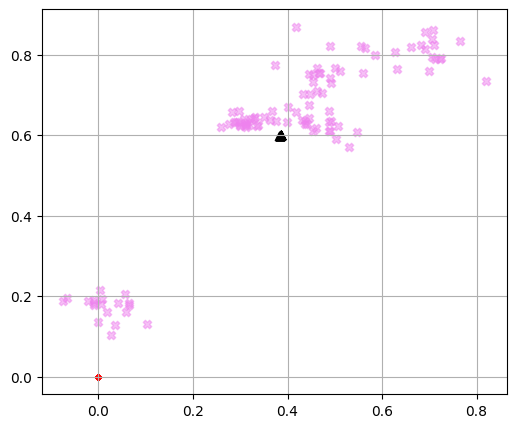

In [4]:
# UAV FLPO MetaData
num_drones = 100
n_drone_clusters = 5
drone_cluster_split = np.random.uniform(0.0, 1.0, n_drone_clusters)
drone_cluster_split = drone_cluster_split / np.sum(drone_cluster_split)
num_facilities = 20
dim_ = 2
print(f"num_drones = {num_drones}\tnum_facilities = {num_facilities}\tdim = {dim_}")

START_locs, F_base, END_locs = generate_dataset(
    num_drones, n_drone_clusters, drone_cluster_split, num_facilities, dim_, device
)

plot_UAV_FLPO(START_locs, END_locs, F_base)
plot_UAV_FLPO_3D(START_locs, END_locs, F_base)

### Load the VRP NET Module

In [5]:
torch.cuda.empty_cache()
model_classes = {"VRPNet_L": VRPNet_L}
weights_address = (
    Path("Saved models") /
    "VRPNet_L_lr1e-04_bs32_ep60000_samples1920000_cities50_inputdim2_"
    "workers0_hidden64_enc1_dec1_heads8_dropout0.30_"
    "train_PO_2025_05_17_22_43_32last_model.pth"
)
vrp_net = utils.load_model(
    weights_address, model_classes, weights_only=True, device=device
)
for param in vrp_net.parameters():
    param.requires_grad = False
print("VRP NET loaded on: ", vrp_net.device)
print(summary(vrp_net))

Model created.
VRP NET loaded on:  cuda
Layer (type:depth-idx)                                                 Param #
VRPNet_L                                                               --
├─LinearAttnEncoder: 1-1                                               2,048
│    └─ModuleList: 2-1                                                 --
│    │    └─MultiheadAttention: 3-1                                    (66,048)
│    │    └─MultiheadAttention: 3-2                                    (66,048)
│    │    └─MultiheadAttention: 3-3                                    (66,048)
│    │    └─MultiheadAttention: 3-4                                    (66,048)
│    │    └─MultiheadAttention: 3-5                                    (66,048)
│    │    └─MultiheadAttention: 3-6                                    (66,048)
│    └─ModuleList: 2-2                                                 --
│    │    └─MultiheadAttention: 3-7                                    (66,048)
│    │    └─MultiheadA

### Load the LSE net module

In [6]:
importlib.reload(LSE_net)
lse_data = torch.load('logSumExp_models/lse_2025_5_1__17_6_31.pth', weights_only=False)
n_inputs = lse_data['n_inputs']
n_outputs = lse_data['n_outputs']
layers = lse_data['layers']
weights = lse_data['model_state_dict']
io_scale = lse_data['io_scale']
lse_net = LSE_net.dnn(n_inputs, n_outputs, layers)
lse_net.to(device)
lse_net.load_state_dict(weights)
lse_net.eval()
for p in lse_net.parameters():
    p.requires_grad = False
print(f'n_inputs: {n_inputs}\nn_outputs: {n_outputs}\nlayers: {layers}\nio_scale: {io_scale}\nLSE_net:\n{summary(lse_net)}')

n_inputs: 3
n_outputs: 1
layers: [20, 20, 10]
io_scale: 1
LSE_net:
Layer (type:depth-idx)                   Param #
dnn                                      --
├─ModuleList: 1-1                        --
│    └─Linear: 2-1                       (80)
│    └─ReLU: 2-2                         --
│    └─Linear: 2-3                       (420)
│    └─ReLU: 2-4                         --
│    └─Linear: 2-5                       (210)
│    └─ReLU: 2-6                         --
│    └─Linear: 2-7                       (11)
Total params: 721
Trainable params: 0
Non-trainable params: 721


### Optimization loop for a single beta

In [9]:
optim_iters = 500
optim_step = 0.01
b_min = 1e-3
beta = 1e3
F_base, FreeEnergy, G = GD.Adam_at_beta(
    F_base, START_locs, END_locs, vrp_net, lse_net, optim_iters, 
    optim_step, b_min, beta, D_max_range=2.0, allowPrint=True)


iter: 0	FreeE: 5.7530e-01 Norm gradient: 0.484
iter: 1	FreeE: 5.6544e-01 Norm gradient: 0.632
iter: 2	FreeE: 5.3847e-01 Norm gradient: 0.797
iter: 3	FreeE: 4.7328e-01 Norm gradient: 0.878
iter: 4	FreeE: 3.8746e-01 Norm gradient: 1.002
iter: 5	FreeE: 3.6715e-01 Norm gradient: 0.971
iter: 6	FreeE: 3.5202e-01 Norm gradient: 0.938
iter: 7	FreeE: 3.3684e-01 Norm gradient: 0.921
iter: 8	FreeE: 3.2235e-01 Norm gradient: 0.899
iter: 9	FreeE: 3.0847e-01 Norm gradient: 0.859
iter: 10	FreeE: 2.9495e-01 Norm gradient: 0.834
iter: 11	FreeE: 2.8177e-01 Norm gradient: 0.806
iter: 12	FreeE: 2.6937e-01 Norm gradient: 0.779
iter: 13	FreeE: 2.5759e-01 Norm gradient: 0.754
iter: 14	FreeE: 2.4650e-01 Norm gradient: 0.730
iter: 15	FreeE: 2.3645e-01 Norm gradient: 0.711
iter: 16	FreeE: 2.2552e-01 Norm gradient: 0.689
iter: 17	FreeE: 2.1534e-01 Norm gradient: 0.665
iter: 18	FreeE: 2.0631e-01 Norm gradient: 0.644
iter: 19	FreeE: 1.9738e-01 Norm gradient: 0.624
iter: 20	FreeE: 1.8871e-01 Norm gradient: 0.603
it

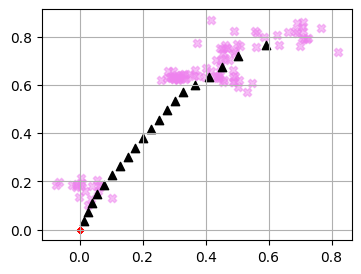

In [10]:
plot_UAV_FLPO(START_locs, END_locs, F_base, (4,3))
plot_UAV_FLPO_3D(START_locs, END_locs, F_base)


### Annealing loop implementation

In [7]:
beta_min = 1e-3
beta_max = 1e5
beta_grow = 3
optim_iters = 100
optim_step = 0.01 # 0.1 for gd0, use < 0.01 for the other two optimizers

F_base, b_arr, F_arr = anneal(
    F_base, START_locs,END_locs, vrp_net, lse_net, optim_iters, optim_step, 
    beta_min, beta_max, beta_grow, D_max_range=2.0, 
    optimizer_name='adam', allowPrint=True)


beta: 1.0000e-03	FreeE: 1.0230	Grad: 1.0245e-02
beta: 3.0000e-03	FreeE: 1.0267	Grad: 1.8020e-04
beta: 9.0000e-03	FreeE: 1.0250	Grad: 1.7823e-04
beta: 2.7000e-02	FreeE: 1.0301	Grad: 3.1565e-04
beta: 8.1000e-02	FreeE: 1.0112	Grad: 3.5229e-04
beta: 2.4300e-01	FreeE: 0.9845	Grad: 1.8317e-04
beta: 7.2900e-01	FreeE: 0.9093	Grad: 2.7291e-04
beta: 2.1870e+00	FreeE: 0.7045	Grad: 1.7901e-03
beta: 6.5610e+00	FreeE: 0.4405	Grad: 1.7718e-03
beta: 1.9683e+01	FreeE: 0.2259	Grad: 6.8609e-04
beta: 5.9049e+01	FreeE: 0.1102	Grad: 2.2576e-03
beta: 1.7715e+02	FreeE: 0.0689	Grad: 5.8087e-04
beta: 5.3144e+02	FreeE: 0.0420	Grad: 2.8337e-04
beta: 1.5943e+03	FreeE: 0.0412	Grad: 1.5537e-04
beta: 4.7830e+03	FreeE: 0.0403	Grad: 3.6840e-04
beta: 1.4349e+04	FreeE: 0.0393	Grad: 3.6437e-04
beta: 4.3047e+04	FreeE: 0.0385	Grad: 2.1734e-04


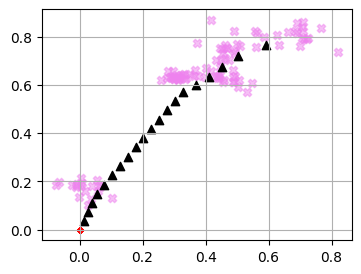

In [10]:
plot_UAV_FLPO(START_locs, END_locs, F_base, (4,3))
plot_UAV_FLPO_3D(START_locs, END_locs, F_base)

### Plot free energy during annealing implementation

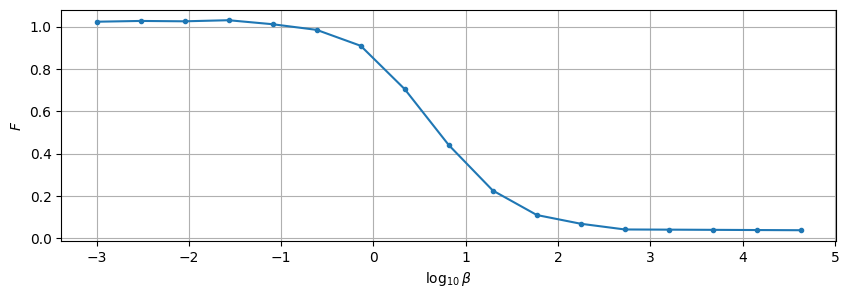

In [9]:
# plot free energy evolution
plt.figure(figsize=(10,3))
plt.plot(np.log(b_arr)/np.log(10), F_arr, marker='.')
plt.ylabel(rf'$F$')
plt.xlabel(rf'$\log_{{10}}\beta$')
plt.grid()
plt.show()